# Failure Modes of the Fourier Neural Operator - AAAI 2025 KGML Bridge Tutorial
#### Sean Current, Ph.D. Candidate, The Ohio State University
#### Co-authors: Rohith Krishnan Sudha, Srinivasan Parthasarathy, Datta Gaitonde
Correspondence: current.33@osu.edu

## Introduction

Welcome! This tutorial serves as an introduction to the Fourier Neural Operator (__[Li, 2020](https://arxiv.org/abs/2010.08895)__), and is focused on providing an overview of the FNO architecture and usage. Usage of the FNO is conveyed via a simple toy problem with data generated directly in the code, allowing users to experiment and adjust parameters to explore the successes and failures of FNO.

### What is a Neural Operator?

Machine learning in Physics can be broadly (though not exclusively) divided into two approaches: Physics-Informed Neural Networks (PINNs), which aim to learn a function described by a given differential equation and initial/boundary conditions, and Neural Operators, which instead learn maps between function spaces, such as the map from initial conditions to the function at a future timestep (__[Azizzadenesheli, 2024](https://www.nature.com/articles/s42254-024-00712-5)__). This approach allows for a greater degree of generalizability to different initial conditions.

### Prerequisites

This tutorial assumes general knowledge of __[PyTorch](https://pytorch.org/)__ and an understanding of the basics of neural networks and back propagation. The following common Python packages are required for the tutorial:
1. `numpy`
2. `pytorch`
3. `matplotlib`
4. `seaborn`

Additionally, the __[neuraloperator](https://github.com/neuraloperator/neuraloperator)__ package can be downloaded via pip to employ the FNO later in the tutorial:
`pip install neuraloperator`

We will start off the tutorial by importing these pacakges:

In [1]:
# Perform necessary imports (all but the neuraloperator package, which will be imported later)

# Packages for computation and data generation
import numpy as np
import torch         
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Architecture of the Fourier Neural Operator
***
The Fourier Neural Operator is a commonly used architecture in Machine Learning in Physics, and operates on data in both the spatial and frequency domains. The general architecture of the FNO is organized as a series of repeated spectral and spatial operations, denoted Fourier Blocks. Each block is made up of a spectral convolution and a channel-wise MLP:

![fno diagram](fno.png "Fourier Neural Operator Architecture")

Spectral convolutions use the Fast Fourier Transform (FFT) to transform discrete data from the spatial to the frequency domain. Let's see what this looks like in code (2D example):

In [2]:
# credit for this code goes to an early version of https://neuraloperator.github.io/dev/index.html
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        """
        Args:
            - in_channels: int, number of input channels
            - out_channels: int, number of output channels
            - modes1: int, number of modes in first dimension in each layer
            - modes2: int, number of modes in second dimension in each layer
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        size1 = x.shape[-2]
        size2 = x.shape[-1]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2, 3])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, device=x.device,
                                dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            torch.einsum("bixy,ioxy->boxy", x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)), dim=[2, 3])
        return x

Notes:

- First, note that we are using `torch.fft.rfftn` to calculate the FFT over `n` dimensions. This is because our input data is real valued. The output of the FFT on real-valued data is Hermitian-symmetric (opposing indicies are complex conjugate pairs); `rfftn` takes note of this, and thus only returns one-side of the output. If the full output is desired, `torch.fft.fftn` can be used instead.

- Second, note that the output of the FFT is complex valued, and thus the weight tensors in SpectralConv2d must also be complex valued. Similarly, we must use complex multiplication to multiply the weight tensors with the relevant data.

- Finally, we use `torch.fft.irfftn` to return our data to the spatial domain. If our data is complex valued, `torch.fft.ifftn` should be used instead.

Next, let's look at how spectral convolutions fit into the architecture of the FNO as a whole. As a reminder, the architecture of the FNO looks like:

![fno diagram](fno.png "Fourier Neural Operator Architecture")

Input data is first lifted into a higher dimensional space using a multi-layer perceptron (MLP). Next, spectral and spatial convolutions are repeatedly applied to the data. Finally, the data is projected back down to the proper output size using an MLP. Here's how it looks in code (2D example):

In [3]:
# this code is a simplified version of https://neuraloperator.github.io/dev/index.html
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, hidden_channels=64, n_layers=4,
                in_channels=3, out_channels=1, lifting_channels=128, projection_channels=128):
        super(FNO2d, self).__init__()
        """
        Args:
            - modes1: int, number of modes in first dimension in each layer
            - modes2: int, number of modes in second dimension in each layer
            - hidden_channels: int, number of hidden dims in Fourier blocks
            - n_layers: int, number of fourier blocks
            - in_channels: int, number of input channels
            - out_channels: int, number of output channels
            - lifting_channels: int, number of lifting channels (MLP before Fourier blocks)
            - projection_channels: int, number of projection channels (MLP after Fourier blocks)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.n_layers = n_layers
        self.hidden_channels = hidden_channels
        
        self.lifting1 = nn.Linear(in_channels, lifting_channels)
        self.lifting2 = nn.Linear(lifting_channels, hidden_channels)
        
        self.sp_convs = nn.ModuleList([SpectralConv2d(
            hidden_channnels, hidden_channels, self.modes1, self.modes2)
            for _ in range(self.n_layers)])

        # authors use Conv1d with kernel size 1, which is essentially a linear layer
        self.ws = nn.ModuleList([nn.Conv1d(hidden_channels, hidden_channels, 1)
                                 for _ in range(self.n_layers)])

        self.projection1 = nn.Linear(hidden_channels, projection_channels)
        self.projection2 = nn.Linear(projection_channels, hidden_channels)
        self.act = F.gelu

    def forward(self, x):
        '''
        Args:
            - x : (batch size, x_grid, y_grid, in_dim)
        Returns:
            - x: (batch size, x_grid, y_grid, out_dim)
        '''
        x = self.lifting1(x)
        x = self.act(x)
        x = self.lifting2(x)
        x = self.act(x)
        
        x = x.permute(0, 3, 1, 2)   # B, C, X, Y
        
        size_x, size_y = x.shape[-2], x.shape[-1]
        length = len(self.ws)
        
        for i, (speconv, w) in enumerate(zip(self.sp_convs, self.ws)):
            x1 = speconv(x)
            x2 = w(x.view(batchsize, self.hidden_channels, -1)).view(batchsize, self.hidden_channels, size_x, size_y)
            x = x1 + x2
            if i != length - 1:
                x = self.act(x)

        x = x.permute(0, 2, 3, 1)  # B, X, Y, C
        x = self.projection1(x)
        x = self.act(x)
        x = self.projection2(x)
        return x


Notes:

- Each Fourier Block is an addition between a spectral convolution and a spatial, channel-wise MLP, followed by a nonlinear activation.

- Note that the authors use Conv1D for channel-wise MLP: this is the same operation as a linear layer applied to the channel dimension! There is a possibility that using a linear layer (matrix multiplication) may be faster than Conv1D.

- Lifting/Projection are simple MLPs.

And that's all there is to it! Next, let's look at how the FNO is actually used on a dataset.

## Experimental Setup
***

Instead of using the implemntation of FNO above, we are going to import the FNO from the `neuraloperators` package:

In [4]:
# pip install neuraloperator
from neuralop.models import FNO

There are two primary reasons we do this:
1. To demonstrate off-the-shelf capabilities of the FNO as implemented by the authors.
2. To simplify our code later-on when we need to use a 1D FNO.

Additionally, we are going to set some hyperparameters for our data generation:

In [5]:
NUM_BATCHES = 500
BATCH_SIZE = 8
NUM_TIMESTEPS = 64
RESOLUTION = 128
SEED = 2025

To demonstrate the success and failure modes of the FNO, we prepare a small dataset with controllable frequency and time evolving features defined by a wave function $y$ dependent on time $t$ and position $x$, with initial phase $\phi_0$. Both the frequency $f$ and phase $\phi$ of the wave will be dependent on time, resulting in functions of the form
$$y(x, t) = \sin(f(t) * (x+\phi(t))).$$

The goals of these toy experiments are three-fold:
1. We wish to show how the performance of FNO models can change drastically depending on the data they are tasked with solving.
2. We wish to show how the performance of FNO models can change depending on how the model is used to solve a problem.
3. We wish to provide an introduction to FNO models and their applications.

The goals of these experiments are **not** to benchmark FNO models (this is why we do not care about using validation/test sets for our experiments!). We only wish to highlight some of the success and pitfalls of training FNO models.

We will use the following `gen_data` function to generate our X and y tensors of shape (BATCH_SIZE, RESOLUTION, NUM_TIMESTEPS, CHANNELS):

In [6]:
def gen_data(function, num_batches, batch_size, num_timesteps, resolution, initial=False):
    """
    Args:
        - function: function, wave function dependent on x, t, and initial_phase
        - num_batches: int, number of batches to generate
        - batch_size: int, number of samples per batch
        - num_timesteps: int, number of timesteps per sample
        - resolution: int, spatial resolution of the wave function
        - initial: bool, if true, include the solution at time 0 as a channel, otherwise add phi_0 as a channel
    """
    X, y = [], []
    
    ts = np.linspace(0, 1, num_timesteps + 1)
    xs = np.linspace(0, 4*np.pi, resolution)
    x, t = np.meshgrid(xs, ts)
    
    for i in range(num_batches * batch_size):
        initial_phase = np.random.uniform(-np.pi, np.pi)
        solution = function(x, t, initial_phase)
        _x, _y = solution[:1], solution[1:]
        
        y.append(_y[None])
        r = np.repeat(_x, _y.shape[0], axis=0)
        rx = np.ones_like(r) * x[:-1]
        rt = np.ones_like(r) * t[:-1]
        if not initial:
            r = np.ones_like(r) * initial_phase
        X.append(np.stack([r, rx, rt], axis=0))
    
    X = np.array(X)
    y = np.array(y)
    return X, y
    

We will also use the following `train`, `view_X_y`, and `view_output` functions to train the model and view the training data and output data, respectively:

In [7]:
def train(X, y, operator, optimizer, loss_function, epochs=10):
    losses = []
    for epoch in range(epochs):
        batches = np.random.permutation(NUM_BATCHES * BATCH_SIZE).reshape(NUM_BATCHES, BATCH_SIZE)
        batch_losses = []
        for samples in batches:
            optimizer.zero_grad()
    
            x_tensor = torch.tensor(X[samples], dtype=torch.float32)
            y_tensor = torch.tensor(y[samples], dtype=torch.float32)
    
            out = operator(x_tensor)
            loss = loss_function(out, y_tensor)
            
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
    
        with torch.autograd.no_grad():
            print(epoch,f"Training Loss: {np.mean(batch_losses):.3g}")
    
        losses.extend(batch_losses)
    return losses

In [8]:
def view_X_y(X, y, idx=0):
    fig, axes = plt.subplots(1, 3, figsize=(10,2))
    for i in range(3):
        axes[i].imshow(X[idx, i], origin='lower')
        axes[i].set_xlabel('x')
    axes[0].set_ylabel('t')
    axes[0].set_title('$\phi$ channel')
    axes[1].set_title('x channel')
    axes[2].set_title('t channel')
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 3), width_ratios=[2, 1])
    axes[0].imshow(y[idx, 0], origin='lower')
    axes[0].set_title('Solution')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('t')
    c_image = np.fft.rfftn(y[idx, 0], axes=[0, 1])
    axes[1].imshow(abs(c_image), origin='lower')
    axes[1].set_title('FFT of solution')
    plt.show()


In [9]:
def view_output(X, y, operator, losses, idx=0):
    with torch.no_grad():
        x_tensor = torch.tensor(X[idx:idx+1], dtype=torch.float32)
        out = operator(x_tensor)
    
        fig, axes = plt.subplots(1, 3, figsize = (18, 3))
        loss_array = np.array(losses).reshape((-1, 10)) # average loss curve over 10 batches to smooth
        batch_mean = loss_array.mean(axis=-1)
        axes[0].plot(np.arange(len(batch_mean)) * 10, batch_mean)
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('MSE')
        axes[1].imshow(y[idx, 0], origin='lower')
        axes[1].grid(False)
        axes[1].set_title('Target Solution')
        axes[1].set_xlabel('x')
        axes[2].set_ylabel('t')
        axes[2].set_yticks([0, NUM_TIMESTEPS//2, NUM_TIMESTEPS-1], ['0', '0.5', '1'])
        axes[1].set_xticks([0, RESOLUTION//2, RESOLUTION-1], ['0', '2$\pi$', '4$\pi$'])
        axes[2].imshow(out[0, 0].numpy(), origin='lower')
        axes[2].grid(False)
        axes[2].set_title('Predicted Solution')
        axes[2].set_xlabel('x')
        axes[1].set_yticks([])
        axes[2].set_xticks([0, RESOLUTION//2, RESOLUTION-1], ['0', '2$\pi$', '4$\pi$'])
        axes[2].spines['right'].set_visible(False)
        axes[2].yaxis.set_label_position("right")
        axes[2].yaxis.tick_right()
        plt.tick_params(right = False)
        plt.subplots_adjust(wspace=0.1)
        plt.show()


## Experiment 1: Baseline
***
Our first experiment will demonstrate the baseline performance of the FNO on a low frequency dataset. We will train the FNO model on the wave function
$$y_{low}(x, t) = \sin((t + 1) * (x + \phi_0 - \pi t)),$$
where the frequency and phase change linearly in time. We generate the data as follows:

(4000, 3, 64, 128) (4000, 1, 64, 128)


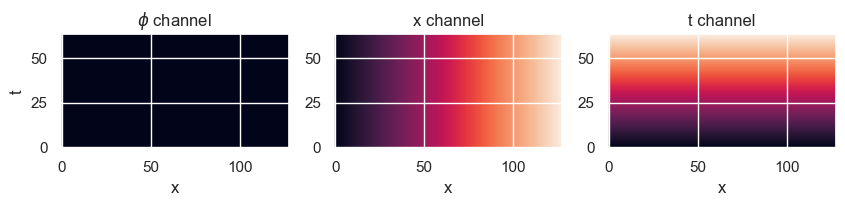

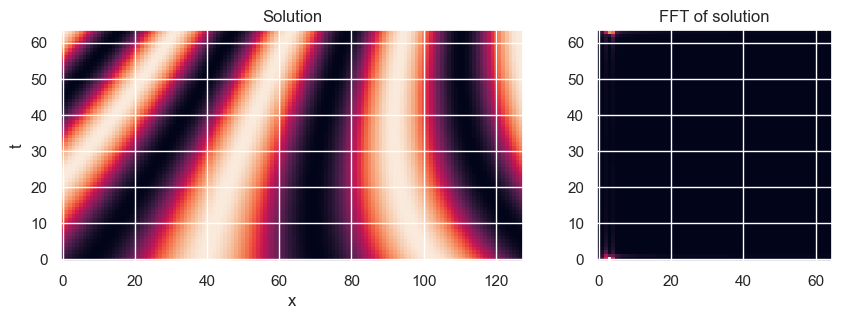

In [10]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq1 = lambda x, t, phi_0: np.sin((t + 1) * (x + phi_0 - np.pi * t))
X, y = gen_data(eq1, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=False)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

We construct and train a small, two-layer FNO model on the data as follows:

0 Training Loss: 0.239
1 Training Loss: 0.0137
2 Training Loss: 0.00652
3 Training Loss: 0.00377
4 Training Loss: 0.00263
5 Training Loss: 0.00201
6 Training Loss: 0.00164
7 Training Loss: 0.00131
8 Training Loss: 0.00113
9 Training Loss: 0.000934


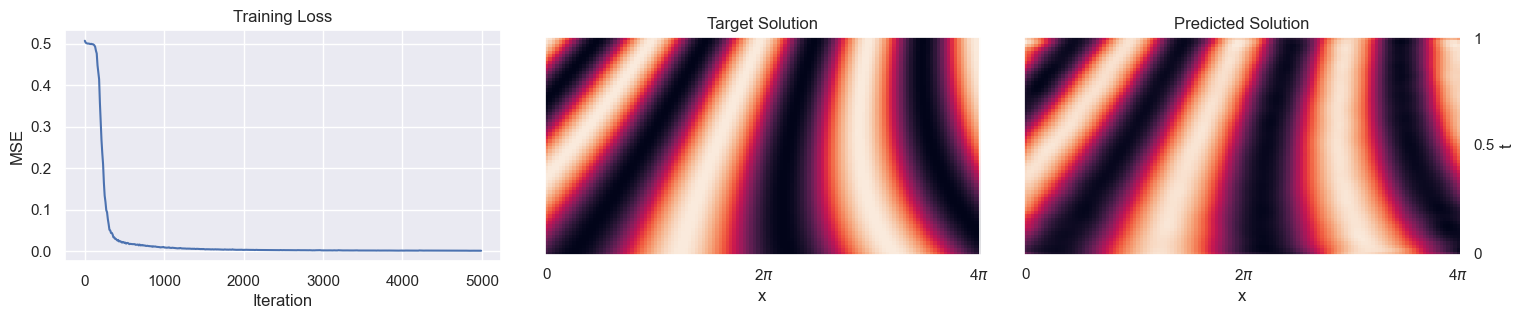

In [11]:
# Shallow 2D FNO with 12 modes (same number of modes used in the original paper)
operator = FNO(n_modes=(12, 12), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
optimizer = torch.optim.Adam(operator.parameters())
loss_function = nn.MSELoss()

#train loop
losses = train(X, y, operator, optimizer, loss_function, epochs=10)
view_output(X, y, operator, losses)

As observed in the training loss and predicted solution for one of the input samples, the FNO model is able to quickly learn the time-dependent low-frequency wave function, producing a solution that is nearly identical to the target solution.

Next, let's look at what happens when the frequency of the wave function is increased.

## Experiment 2: High Frequency
***
Our second experiment will demonstrate the performance of the FNO on a higher frequency dataset. We will train the FNO model on the same wave function as the baseline experiment, but with a frequency four times higher:
$$y_{high}(x, t) = \sin(4(t + 1) * (x + \phi_0 - \pi t)).$$

We initialize and train the model identically to the baseline:

(4000, 3, 64, 128) (4000, 1, 64, 128)


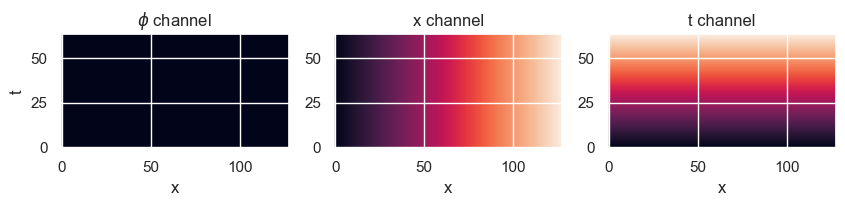

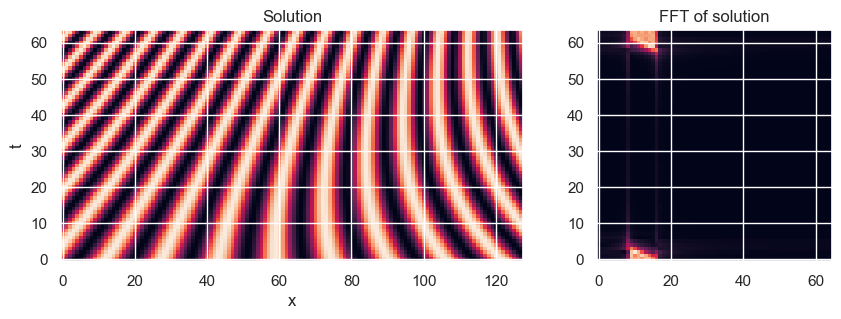

In [12]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq2 = lambda x, t, phi_0: np.sin(4 * (t + 1) * (x + phi_0 - np.pi * t))
X, y = gen_data(eq2, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=False)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

0 Training Loss: 0.5
1 Training Loss: 0.5
2 Training Loss: 0.498
3 Training Loss: 0.409
4 Training Loss: 0.254
5 Training Loss: 0.157
6 Training Loss: 0.118
7 Training Loss: 0.0952
8 Training Loss: 0.0828
9 Training Loss: 0.0731


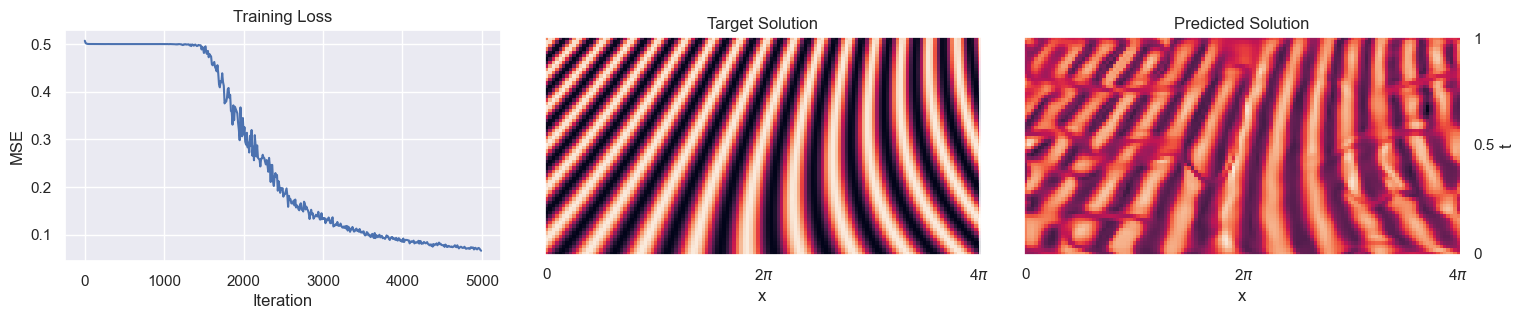

In [13]:
# Shallow 2D FNO with 12 modes (same number of modes used in the original paper)
operator = FNO(n_modes=(12, 12), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
optimizer = torch.optim.Adam(operator.parameters())
loss_function = nn.MSELoss()

#train loop
losses = train(X, y, operator, optimizer, loss_function, epochs=10)
view_output(X, y, operator, losses)

As observed in the loss curve and predicted solution, the FNO model performs significantly worse on the higher frequency data. Not only does the model struggle to learn in the first 1500 iterations, but when it does finally begin to miminize the loss it is in a slow and noisy manner, demonstrating that the mode struggles to learn the high-frequency problem.

The model's struggle is also apparent in the predicted solution, which has numerous distortions throughout the prediction space. This goes to show how a FNO that performs well at low frequency regimes can break on high frequency regimes. Notably, the performance of the FNO could be improved by raising the number of modes used in the FNO: however, including higher modes can introduce unnecessary information to the model or be computationally costly, further compounding the difficulty of modeling high-frequency features.

Next, let's see how our same model fares when multiple frequency components are present.

## Experiment 3: Low and High Frequency Features
***
In this experiment, we test to see how the model fares when both high and low frequency components are present. To do this, we add the previous low and high frequency solutions together to construct the combined solution:
$$y_{same}(x, t) = \sin((t + 1) * (x + \phi_0 - \pi t)) + \sin(4(t + 1) * (x + \phi_0 - \pi t)).$$

We denote this solution $y_{same}$ because both the low and high frequency components share the same time dependency for both phase and frequency.

Following the same initialization and training procedures as before:

(4000, 3, 64, 128) (4000, 1, 64, 128)


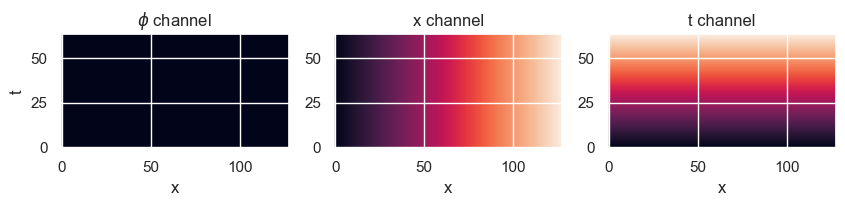

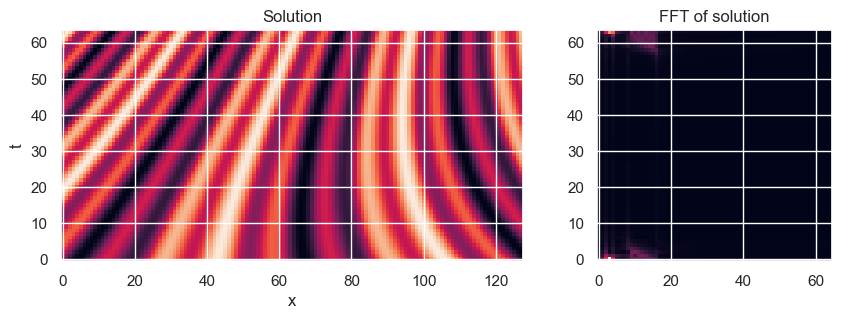

In [14]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq3 = lambda x, t, phi_0: np.sin((t + 1) * (x + phi_0 - np.pi * t)) + np.sin(4 * (t + 1) * (x + phi_0 - np.pi * t))
X, y = gen_data(eq3, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=False)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

0 Training Loss: 0.735
1 Training Loss: 0.33
2 Training Loss: 0.169
3 Training Loss: 0.107
4 Training Loss: 0.0816
5 Training Loss: 0.0678
6 Training Loss: 0.0582
7 Training Loss: 0.0521
8 Training Loss: 0.0475
9 Training Loss: 0.0434


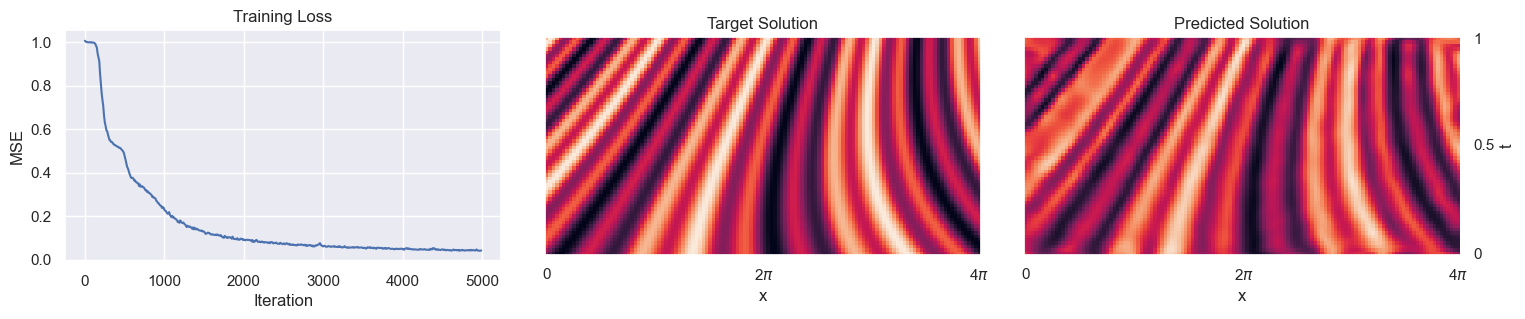

In [15]:
# Shallow 2D FNO with 12 modes (same number of modes used in the original paper)
operator = FNO(n_modes=(12, 12), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
optimizer = torch.optim.Adam(operator.parameters())
loss_function = nn.MSELoss()

#train loop
losses = train(X, y, operator, optimizer, loss_function, epochs=10)
view_output(X, y, operator, losses)

While there are still many distortions present in the solution, they are somewhat masked by the model's strong performance on the lower frequency result. Notably, the loss curve appears "hilly", as the model learns lower frequency features first, before learning the high frequency features. This occurence is known as "spectral bias," in which artificial neural networks tend to fit low frequency features before high frequency features.

This is more apparent in the next experiment, which progresses the phase of the high frequency signal differently from that of the low frequency signal.

## Experiment 4: Low and High Frequency Features with Different Phase Progression
***
In our fourth experiment, we change the direction of phase progression for the high frequency signal. Instead of
$$y_{same}(x, t) = \sin((t + 1) * (x + \phi_0 - \pi t)) + \sin(4(t + 1) * (x + \phi_0 - \pi t))$$
as before, we now have
$$y_{diff}(x, t) = \sin((t + 1) * (x + \phi_0 - \pi t)) + \sin(4(t + 1) * (x + \phi_0 + \pi t)),$$
denoted $y_{diff}$ to signify the different phase progressions between the low frequency and high frequency features.

Following the same initialization and training procedures as before:

(4000, 3, 64, 128) (4000, 1, 64, 128)


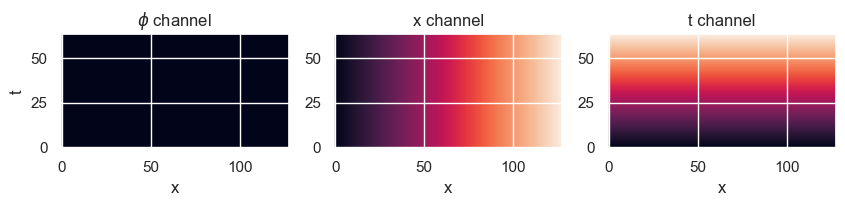

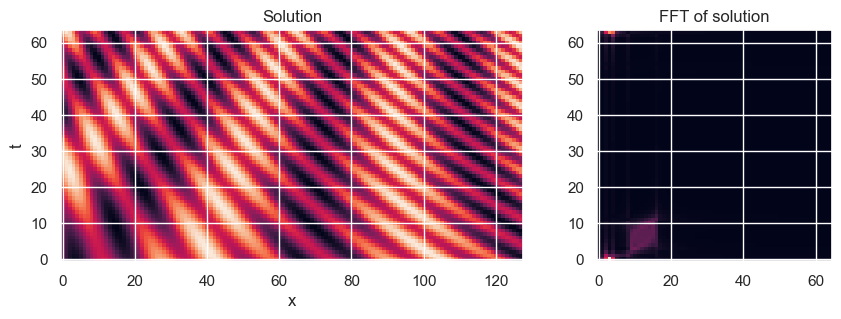

In [16]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq4 = lambda x, t, phi_0: np.sin((t + 1) * (x + phi_0 - np.pi * t)) + np.sin(4 * (t + 1) * (x + phi_0 + np.pi * t))
X, y = gen_data(eq4, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=False)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

0 Training Loss: 0.739
1 Training Loss: 0.487
2 Training Loss: 0.346
3 Training Loss: 0.225
4 Training Loss: 0.171
5 Training Loss: 0.143
6 Training Loss: 0.124
7 Training Loss: 0.109
8 Training Loss: 0.098
9 Training Loss: 0.0899


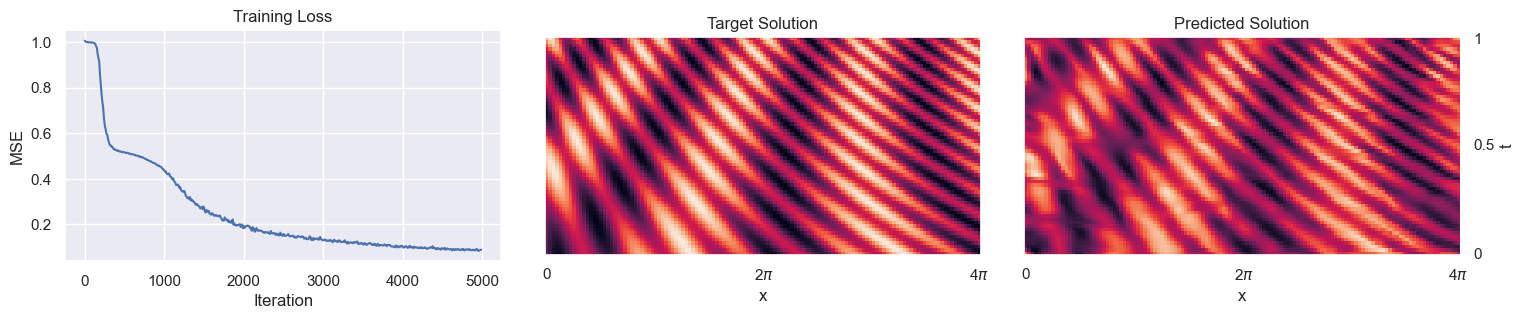

In [17]:
# Shallow 2D FNO with 12 modes (same number of modes used in the original paper)
operator = FNO(n_modes=(12, 12), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
optimizer = torch.optim.Adam(operator.parameters())
loss_function = nn.MSELoss()

#train loop
losses = train(X, y, operator, optimizer, loss_function, epochs=10)
view_output(X, y, operator, losses)

Here, the model's ability to learn low and high frequency components is much more apparent. Similar distortions to the high frequency experiment can be observed in the predicted solution, and the training loss clearly shows a division in the model's ability to learn different frequency ranges.

Furthermore, the model plateaus at a loss higher than observed in the low/high frequency case when both frequencies have the same phase progression, indicating that the model is advatanged when different frequencies are treated similarly.

These experiments go to show the FNO's sensitivity to setting of the number of modes, as well as what can occur when the number of modes is too low. Additionally, we demonstrate that different frequency components are not attended to equally by the FNO model.

For our final round of experiments, let us look at what happens when the FNO is applied in an auto-regressive setting.

## Experiment 5: Auto-Regressive FNO
***
In this experiment, we apply the FNO in an auto-regressive manner to demonstrate the occurence of rollout error.

We adapt our initial problem to an auto-regressive variant $y_{AR}(x, t) = \sin((t+1) * (x+\phi_{AR}(t)))$, where the slope of change for the phase function is also dependent on the initial phase $\phi_0$, resulting in an auto-regressive phase function:
$$\phi_{AR}(t) = \phi_0 + \phi_0 t = \phi_0 (1 + t) = \phi_{AR}(t-1) + \phi_0.$$

We generate the data and train the model as before with the adjusted equation for our baseline comparison: 

(4000, 3, 64, 128) (4000, 1, 64, 128)


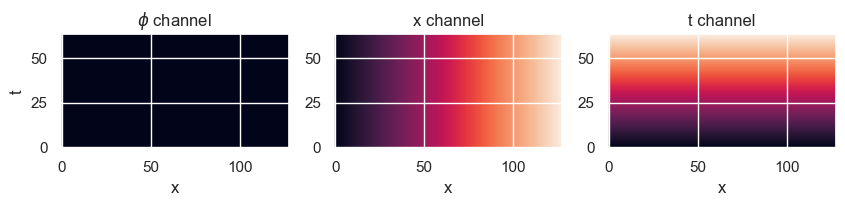

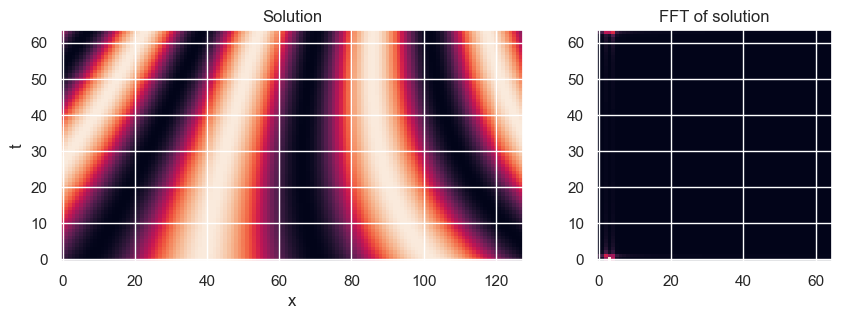

In [18]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq5 = lambda x, t, phi_0: np.sin((t + 1) * (x + phi_0 * (1 + t)))
X, y = gen_data(eq5, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=False)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

0 Training Loss: 0.299
1 Training Loss: 0.0203
2 Training Loss: 0.00975
3 Training Loss: 0.00615
4 Training Loss: 0.00429
5 Training Loss: 0.00329
6 Training Loss: 0.00258
7 Training Loss: 0.00219
8 Training Loss: 0.00194
9 Training Loss: 0.00146


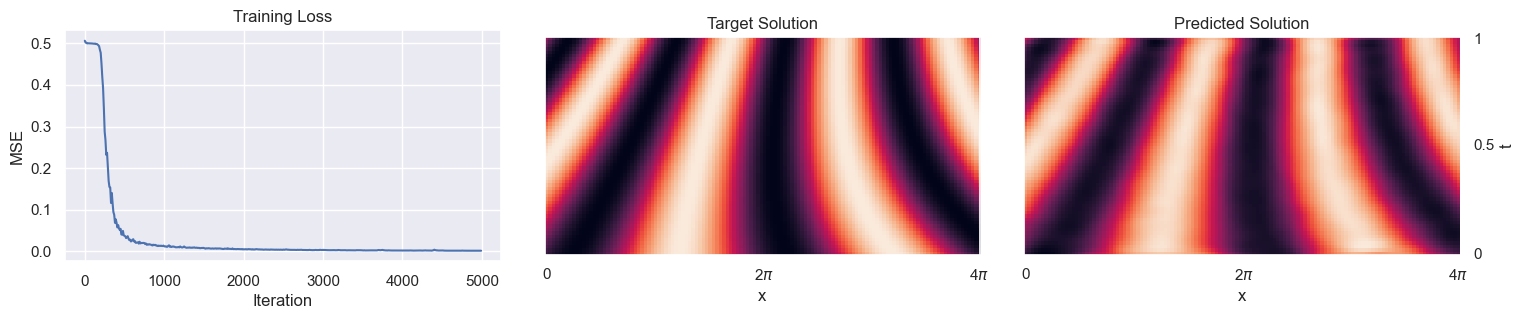

In [19]:
# Shallow 2D FNO with 12 modes (same number of modes used in the original paper)
operator = FNO(n_modes=(12, 12), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
optimizer = torch.optim.Adam(operator.parameters())
loss_function = nn.MSELoss()

#train loop
losses = train(X, y, operator, optimizer, loss_function, epochs=10)
view_output(X, y, operator, losses)

Like before, the baseline model is able to quickly and effectively model the entire solution. Notably, the baseline model is predicting the entire solution in both space and time at once, not autoregressively. To transition to an auto-regressive implementation, we need to change a few details of our implementation:
1. Instead of providing the model with the information of $\phi_0$, we instead want to provide the model with the initial solution $y(x, 0)$.
2. Because we are predicting timestep-by-timestep, we only see a row of data at a time, thus we need to switch to a 1D FNO.
3. We want to train the model to predict auto-regressively. To do so, we let the model predict two timesteps during training and average the loss over both timesteps.

We generate the data with the `initial=True` setting to provide the model with the initial solution:

(4000, 3, 64, 128) (4000, 1, 64, 128)


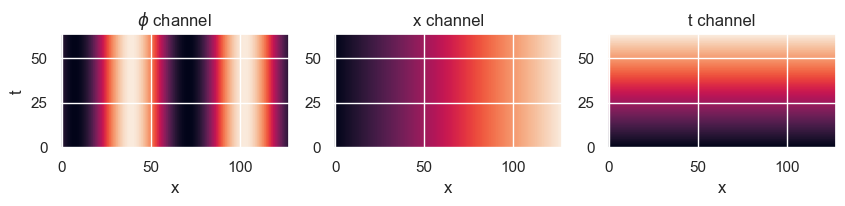

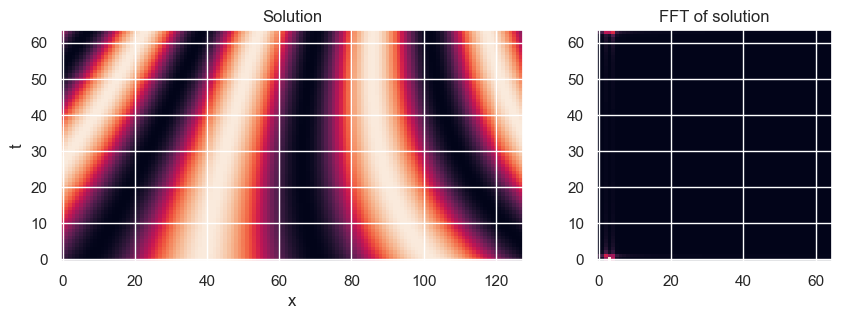

In [20]:
np.random.seed(SEED)
torch.manual_seed(SEED)

# Datagen (simple wave with moving phase and frequency)
eq5 = lambda x, t, phi_0: np.sin((t + 1) * (x + phi_0 * (1 + t)))
X, y = gen_data(eq5, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, num_timesteps=NUM_TIMESTEPS, resolution=RESOLUTION, initial=True)
print(X.shape, y.shape)

# view example index
view_X_y(X, y)

Now we can construct our 1D FNO model:

In [21]:
# Shallow 1D FNO with 12 modes (same number of modes used in the original paper)
ar_operator = FNO(n_modes=(12,), hidden_channels=8, n_layers=2,
                in_channels=3, out_channels=1, lifting_channels=16, projection_channels=16)
ar_optimizer = torch.optim.Adam(ar_operator.parameters())
loss_function = nn.MSELoss()

Finally, we train the model using a modified auto-regressive training loop:

In [22]:
#autoregressive train loop
ar_losses = []
for epoch in range(10):
    batches = np.random.permutation(NUM_BATCHES * BATCH_SIZE).reshape(NUM_BATCHES, BATCH_SIZE)
    time_index = np.random.randint(0, NUM_TIMESTEPS - 2, size=BATCH_SIZE)
    batch_losses = []
    for samples in batches:
        ar_optimizer.zero_grad()

        x_tensor = torch.tensor(X[samples, :, time_index], dtype=torch.float32)
        y_tensor_0 = torch.tensor(y[samples, :, time_index], dtype=torch.float32)
        y_tensor_1 = torch.tensor(y[samples, :, time_index + 1], dtype=torch.float32)
        y_tensor_2 = torch.tensor(y[samples, :, time_index + 2], dtype=torch.float32)
        x_tensor = torch.concatenate([y_tensor_0, x_tensor[:, 1:]], dim=1)
        
        out = ar_operator(x_tensor)
        loss = loss_function(out, y_tensor_1)

        x_tensor = torch.concatenate([out, x_tensor[:, 1:]], dim=1)
        x_tensor[:, -1] += 1 / (NUM_TIMESTEPS + 1)
        
        out = ar_operator(x_tensor)
        loss += loss_function(out, y_tensor_2)

        loss.backward()
        ar_optimizer.step()
        
        batch_losses.append(loss.item())

    with torch.autograd.no_grad():
        print(epoch,f"Training Loss: {np.mean(batch_losses):.3g}")

    ar_losses.extend(batch_losses)


0 Training Loss: 0.186
1 Training Loss: 0.0194
2 Training Loss: 0.0156
3 Training Loss: 0.0212
4 Training Loss: 0.0225
5 Training Loss: 0.0166
6 Training Loss: 0.0211
7 Training Loss: 0.0201
8 Training Loss: 0.0163
9 Training Loss: 0.0192


We must also predict auto-regressively:

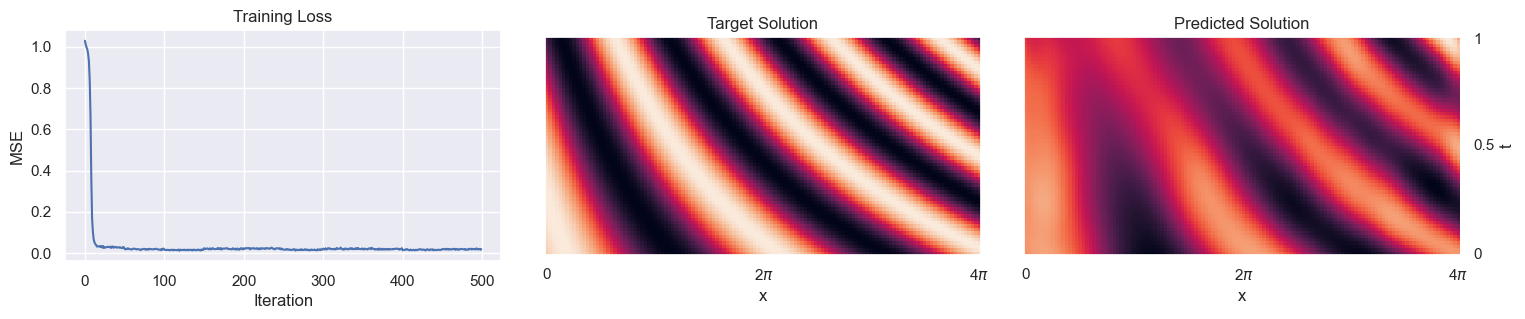

In [23]:
with torch.no_grad():
    idx = np.random.randint(len(X))
    x_tensor = torch.tensor(X[idx:idx+1, :, 0], dtype=torch.float32)
    y_tensor_0 = torch.tensor(y[idx:idx+1, :, 0], dtype=torch.float32)
    x_tensor = torch.concatenate([y_tensor_0, x_tensor[:, 1:]], dim=1)
    
    outs = []
    for i in range(NUM_TIMESTEPS):
        out = ar_operator(x_tensor)
        x_tensor = torch.concatenate([out, x_tensor[:, 1:]], dim=1)
        x_tensor[:, -1] += 1 / (NUM_TIMESTEPS + 1)
        outs.append(x_tensor)
    out = torch.stack(outs, dim=2)

    fig, axes = plt.subplots(1, 3, figsize = (18, 3))
    loss_array = np.array(ar_losses).reshape((-1, 10))
    batch_mean = loss_array.mean(axis=-1)
    axes[0].plot(batch_mean)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('MSE')
    axes[1].imshow(y[idx, 0], origin='lower')
    axes[1].grid(False)
    axes[1].set_title('Target Solution')
    axes[1].set_xlabel('x')
    axes[2].set_ylabel('t')
    axes[2].set_yticks([0, NUM_TIMESTEPS//2, NUM_TIMESTEPS-1], ['0', '0.5', '1'])
    axes[1].set_xticks([0, RESOLUTION//2, RESOLUTION-1], ['0', '2$\pi$', '4$\pi$'])
    axes[2].imshow(out[0, 0].to('cpu').numpy(), origin='lower')
    axes[2].grid(False)
    axes[2].set_title('Predicted Solution')
    axes[2].set_xlabel('x')
    axes[1].set_yticks([])
    axes[2].set_xticks([0, RESOLUTION//2, RESOLUTION-1], ['0', '2$\pi$', '4$\pi$'])
    axes[2].spines['right'].set_visible(False)
    axes[2].yaxis.set_label_position("right")
    axes[2].yaxis.tick_right()
    plt.tick_params(right = False)
    plt.subplots_adjust(wspace=0.1)
    plt.show()

Despite the model effectively minimizing the auto-regressive loss function, small errors continuously add up during auto-regressive prediction, resulting in poor and noisy results at higher timesteps. This is a commonly observed issue in many auto-regressive models and the FNO is not immune. This problem is exacerbated by the kinds of problems FNO models are commonly applied to, which can be highly sensitive to differences in input features.

## Examples of FFT on Real Datasets
***
To close out this tutorial, we apply and visualize the Fast Fourier Transform (FFT) on two real world datasets. For both datasets, we will view the raw 2D spatial data for a single timestep, the FFT of the data, and then the inverse FFT of the FFT transformed data for the entire transformation as well as the mode-truncated transformation. Note that instead of viewing the FFT directly, we are instead visualizing log(fft) for easier viewing.

The first dataset is a simulation of the incompressible Navier-Stokes equations using the vorticity formulation from the original FNO paper (__[Li, 2020](https://arxiv.org/abs/2010.08895)__):

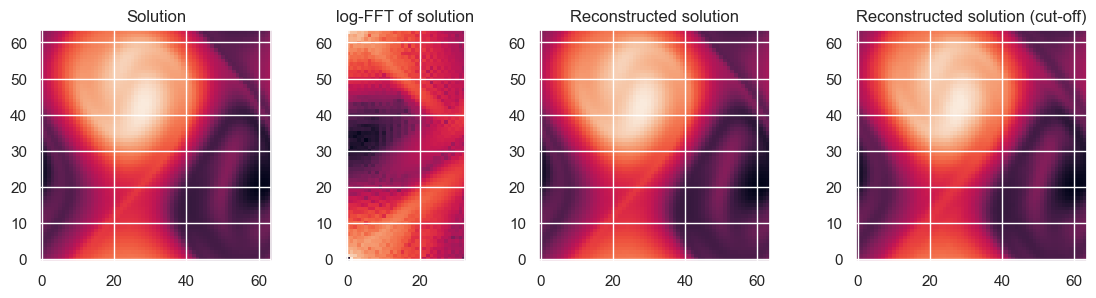

In [24]:
y = np.load('ns_data.npy')
idx = -1
kmax = 12

fig, axes = plt.subplots(1, 4, figsize=(14, 3), width_ratios=[2, 1, 2, 2])
axes[0].imshow(y[idx], origin='lower')
axes[0].set_title('Solution')
c_image = np.fft.rfftn(y[idx], axes=[0, 1])
axes[1].imshow(np.log(abs(c_image)), origin='lower')
axes[1].set_title('log-FFT of solution')
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[2].imshow(image, origin='lower')
axes[2].set_title('Reconstructed solution')
# cut off modes
c_image[kmax:-kmax] = 0
c_image[:, kmax:] = 0
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[3].imshow(image, origin='lower')
axes[3].set_title('Reconstructed solution (cut-off)')
plt.show()

As observed in the plots above, the reconstructed solution with mode-truncation closely matches the true solution, indicating that 12 modes is sufficient to represent the spatial data.

In contrast, let us look at the density component for a compressible Navier-Stokes simulation from PDEBench (__[Takamoto, 2022](https://proceedings.neurips.cc/paper_files/paper/2022/hash/0a9747136d411fb83f0cf81820d44afb-Abstract-Datasets_and_Benchmarks.html)__):

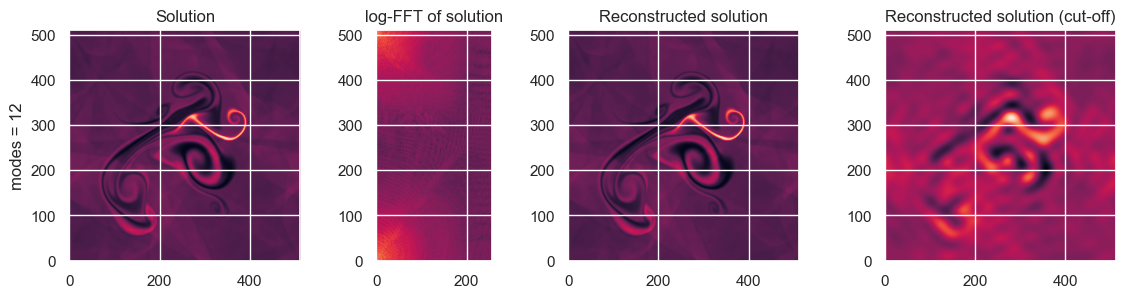

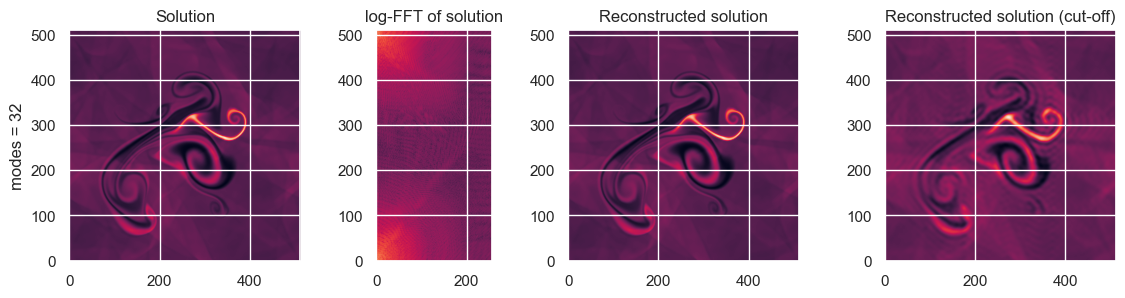

In [25]:
y = np.load('ns_data_cfd.npy')
idx = -1
kmax = 12

fig, axes = plt.subplots(1, 4, figsize=(14, 3), width_ratios=[2, 1, 2, 2])
axes[0].imshow(y[idx], origin='lower')
axes[0].set_title('Solution')
axes[0].set_ylabel(f'modes = {kmax}')
c_image = np.fft.rfftn(y[idx], axes=[0, 1])
axes[1].imshow(np.log(abs(c_image)), origin='lower')
axes[1].set_title('log-FFT of solution')
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[2].imshow(image, origin='lower')
axes[2].set_title('Reconstructed solution')
# cut off modes
c_image[kmax:-kmax] = 0
c_image[:, kmax:] = 0
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[3].imshow(image, origin='lower')
axes[3].set_title('Reconstructed solution (cut-off)')
plt.show()

kmax = 32
fig, axes = plt.subplots(1, 4, figsize=(14, 3), width_ratios=[2, 1, 2, 2])
axes[0].imshow(y[idx], origin='lower')
axes[0].set_title('Solution')
axes[0].set_ylabel(f'modes = {kmax}')
c_image = np.fft.rfftn(y[idx], axes=[0, 1])
axes[1].imshow(np.log(abs(c_image)), origin='lower')
axes[1].set_title('log-FFT of solution')
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[2].imshow(image, origin='lower')
axes[2].set_title('Reconstructed solution')
# cut off modes
c_image[kmax:-kmax] = 0
c_image[:, kmax:] = 0
image = np.fft.irfftn(c_image, axes=[0, 1])
axes[3].imshow(image, origin='lower')
axes[3].set_title('Reconstructed solution (cut-off)')
plt.show()

In constrast to the incompressible flow example, the reconstructed solution for the compressible flow dataset is clearly insufficient, resulting in significantly lower fidelity and detail in the reconstruction.

When the number of modes is increased to 32 from 12, the reconstruction is signifanctly closer to the true solution, though small distortions are still evident. Notably, the increase from 12 to 32 modes can represent a significant resource cost in the FNO computation, particularly for high-resolution simulations.

## Conclusion
***
This tutorial serves as an introduction to the Fourier Neural Operator, a commonly used architecture in Machine Learning for Physics.

Fourier Neural Operators are hghly capable architectures, but they are prone to error when applied with improper care. Notably, FNO models are highly sensitive to the number of modes used in the FFT, which controls the amount of information the FNO is capable of learning.

FNO models are also sensitive to auto-regressive training and prediction. Like other auto-regressive models, FNO models are susceptible to rollout error when applied auto-regressively.

We hope that this tutorial has helped inform you of the capabilities and limitations of FNO models, and provided greater insight into the workings of the Fast Fourier Transform.

If you have any questions or comments, please don't hesitate to reach out at current.33@osu.edu.

## References
1. Li, Zongyi, et al. "Fourier neural operator for parametric partial differential equations." arXiv preprint arXiv:2010.08895 (2020).
2. Azizzadenesheli, Kamyar, et al. "Neural operators for accelerating scientific simulations and design." Nature Reviews Physics (2024): 1-9.
3. Kossaifi, Jean, et al. "A Library for Learning Neural Operators", ArXiV, 2024. doi:10.48550/arXiv.2412.10354.
4. Kovachki, Nikola, et al. “Neural Operator: Learning Maps Between Function Spaces”, JMLR, 2021. doi:10.48550/arXiv.2108.08481.
5. Takamoto, Makoto, et al. "Pdebench: An extensive benchmark for scientific machine learning." Advances in Neural Information Processing Systems 35 (2022): 1596-1611.